In [1]:
import os
import numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder

from PIL import Image
import matplotlib.pyplot as plt
import scipy.ndimage.morphology as morph

# tensor to pil
to_pil = transforms.ToPILImage()
os.listdir("../_data_/DAVIS")

['JPEGImages', 'Annotations', 'README.md', 'ImageSets']

In [2]:
# decive
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# way to the data folders
folder_data = "../_data_/DAVIS/JPEGImages/480p"
folder_mask = "../_data_/DAVIS/Annotations/480p"
device

device(type='cuda', index=0)

In [3]:
imgs_data = ImageFolder(folder_data)
mask_data = ImageFolder(folder_mask)
timesteps = 2                               # arg.timesteps
batch_size = 16                             # arg.batch_size
num_epochs = 25                             # arg.num_epochs

gru_nan = False                             # arg.gru_nan (True or False)

In [4]:
# make labels for folder
transform = transforms.Compose([
                              transforms.Resize((128, 128)),
                              transforms.ToTensor(),
                              ])

def channel_pos_func(object):
    mask_channels = (transform(object[0].convert("L")) == 0).float()
    for i in range(len(mask_data.classes)):
        if i == object[1]:
            mask_channels = torch.cat([mask_channels, transform(object[0].convert("L"))], dim=0)
        else:
            mask_channels = torch.cat([mask_channels, torch.zeros(1, 128, 128)], dim=0)
    return mask_channels

In [5]:
# make dataset iterable
class Timestep_2_Davis_480p(Dataset):
    def __init__(self):
        super().__init__()
        self.imgs_data = ImageFolder(folder_data)
        self.mask_data = ImageFolder(folder_mask)
        self.len = len(imgs_data)
        self.transform = transforms.Compose([
                                             transforms.Resize((128, 128)),
                                             transforms.ToTensor()
                                            ])
        self.timesteps = timesteps

    def __getitem__(self, idx):
        label = self.imgs_data[idx][1]+1
        img_1 = self.transform(self.imgs_data[idx][0].convert("RGB")).unsqueeze(0)
        if (idx+2) <= len(self.imgs_data):
            img_2 = self.transform(self.imgs_data[idx+1][0].convert("RGB")).unsqueeze(0)
        elif (idx+2) > self.len:
            img_2 = torch.rand_like(img_1)
        else:
            img_2 = torch.rand_like(img_1)
        imgs = torch.cat((img_1, img_2), 0)
        mask_channels_1 = channel_pos_func(self.mask_data[idx]).unsqueeze(0)
        if (idx+2) <= len(self.imgs_data):
            mask_channels_2 = channel_pos_func(self.mask_data[idx+1]).unsqueeze(0)
        elif (idx+2) > self.len:
            mask_channels_2 = torch.rand_like(mask_channels_1)
        else:
            mask_channels_2 = torch.rand_like(mask_channels_1)
        mask_channels = torch.cat((mask_channels_1, mask_channels_2), 0)
        return imgs, mask_channels, label

    def __len__(self):
        return len(self.imgs_data)
  
dataset = Timestep_2_Davis_480p()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,                                # arg.bacth_size
                          num_workers=1,
                          shuffle=True)

In [6]:
# create class GruCell
class GruCell(nn.Module):
    
    def __init__(self, channel):
        super(GruCell, self).__init__()
        self.update_gate = nn.Conv2d(in_channels=channel+channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        
        self.reset_gate = nn.Conv2d(in_channels=channel+channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        
        self.memory_gate_for_input = nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        self.memory_gate_for_hidden = nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()        

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.update_gate(input)
        update_gate = self.sig((update_gate)) ### output after update gate
        
        reset_gate = self.reset_gate(input)
        reset_gate = self.sig((reset_gate)) ### output after reset gate
        
        memory_gate_for_input = self.memory_gate_for_input(x)
        memory_gate_for_hidden = self.memory_gate_for_hidden(hidden)

        memory_content = self.tanh((memory_gate_for_input + (reset_gate * memory_gate_for_hidden))) ### output for reset gate(affects how the reset gate do work)
        
        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden

In [15]:
# create class GruCell
class GruCell(nn.Module):
    
    def __init__(self, channel):
        super(GruCell, self).__init__()
        self.update_gate = nn.Conv2d(in_channels=channel+channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        
        self.reset_gate = nn.Conv2d(in_channels=channel+channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        
        self.memory_gate_for_input = nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        self.memory_gate_for_hidden = nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1)
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()        

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.update_gate(input)
        update_gate = self.sig((update_gate)) ### output after update gate
        
        reset_gate = self.reset_gate(input)
        reset_gate = self.sig((reset_gate)) ### output after reset gate
        
        memory_gate_for_input = self.memory_gate_for_input(x)
        memory_gate_for_hidden = self.memory_gate_for_hidden(hidden)

        memory_content = self.tanh((memory_gate_for_input + (reset_gate * memory_gate_for_hidden))) ### output for reset gate(affects how the reset gate do work)
        # релу вместо тенгенца иили убрать или после гру 
        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden


# create class Gru
class Gru(nn.Module):

    def __init__(self, channels_size, input_size):
        super(Gru, self).__init__()
        self.batch_size = batch_size
        self.timesteps = timesteps
        self.channels_size = channels_size
        self.input_size = input_size
        self.hidden_size = (self.batch_size, channels_size, input_size, input_size)
        
        self.gru_layer0 = GruCell(channels_size)
        self.init_hidden = torch.zeros(self.hidden_size).to(device)
        self.gru_nan = gru_nan


    def forward(self, x):   
        x_cells = None
        if self.gru_nan == False:
            try:
                x = x.reshape(batch_size, timesteps, self.channels_size, self.input_size, self.input_size)
                x = x.permute(1, 0, 2, 3, 4)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], self.init_hidden)
                    else:
                        x_i, hidden = self.gru_layer0(x[i], hidden)
                        x_cells = torch.stack((x_cells, x_i))
            ##### FOR LAST BATCH
            except RuntimeError:
                x = x.reshape(15, timesteps, self.channels_size, self.input_size, self.input_size) #last batch is (15), but batch_size = 16, #arg.timesteps = 2 
                x = x.permute(1, 0, 2, 3, 4)
                hidden_zero = torch.zeros_like(x)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], hidden_zero[0])
                    else:
                        x_i, hidden = self.gru_layer0(x[i], hidden)
                        x_cells = torch.stack((x_cells, x_i))
            #####
        elif self.gru_nan == True:  
            try:
                x = x.reshape(batch_size, timesteps, self.channels_size, self.input_size, self.input_size)
                x = x.permute(1, 0, 2, 3, 4)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], self.init_hidden)
                    else:
                        x_i, hidden = self.gru_layer0(x[i], self.init_hidden)
                        x_cells = torch.stack((x_cells, x_i))
            ##### FOR LAST BATCH
            except RuntimeError:
                x = x.reshape(15, timesteps, self.channels_size, self.input_size, self.input_size) #last batch is (15), but batch_size = 16, #arg.timesteps = 2 
                x = x.permute(1, 0, 2, 3, 4)
                hidden_zero = torch.zeros_like(x)
                for i in range(timesteps):
                    if x_cells is None:
                        x_cells, hidden = self.gru_layer0(x[i], hidden_zero[0])
                    else:
                        x_i, hidden = self.gru_layer0(x[i], hidden)
                        x_cells = torch.stack((x_cells, x_i))
        else:
            print('gru_nan can be only True or False')
            quit()

        return x_cells  

In [16]:
# download backbone model
base_model = models.resnet18(pretrained=True)
base_layers = list(base_model.children())

In [17]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=False)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)

        self.timesteps = timesteps
        self.batch_size = batch_size      

        self.gru_layer0 = Gru(64, 64) # channels_size=64, input_size=64
        self.gru_layer1 = Gru(64, 32)
        self.gru_layer2 = Gru(128, 16)
        self.gru_layer3 = Gru(256, 8)


    def forward(self, input):
        input = input.reshape(-1, 3, 128, 128)

        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        rnn0 = self.gru_layer0(layer0)
        rnn0 = rnn0.reshape(-1, 64, 64, 64) #chennels_size=64 input_size 64
     
        layer1 = self.layer1(layer0)
        rnn1 = self.gru_layer1(layer1)
        rnn1 = rnn1.reshape(-1, 64, 32, 32) #chennels_size=64 input_size 64


        layer2 = self.layer2(layer1)
        rnn2 = self.gru_layer2(layer2)
        rnn2 = rnn2.reshape(-1, 128, 16, 16) #chennels_size=64 input_size 64

        layer3 = self.layer3(layer2)  
        rnn3 = self.gru_layer3(layer3)
        rnn3 = rnn3.reshape(-1, 256, 8, 8) #chennels_size=64 input_size 64

        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, rnn3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, rnn2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, rnn1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, rnn0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)  
        
        out = self.conv_last(x)  
        
        return out

In [18]:
model = ResNetUNet(51)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(prediction, target, bce_weight=0.3):
    try:
        prediction = prediction.reshape(timesteps*batch_size, 51, 128, 128)
        target = target.reshape(timesteps*batch_size, 51, 128, 128)
    except RuntimeError:
        prediction = prediction.reshape(timesteps*15, 51, 128, 128) # last_batch = 15
        target = target.reshape(timesteps*15, 51, 128, 128)
    bce = F.binary_cross_entropy_with_logits(prediction, target)
    prediction = F.sigmoid(prediction)
    dice = lossy(prediction, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

def lossy(x, y):
    return (((x - y)**2).sum(dim=1)).sum()/(256**2)

criterion = torch.nn.BCEWithLogitsLoss()

In [19]:
def IoU(pred, target):
    tanh = nn.Tanh()
    pred = tanh(pred)
    pred = pred.contiguous() * (-1)
    target = target.contiguous() * (-1)  
    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (torch.abs(intersection))/(torch.abs(pred.sum(dim=2).sum(dim=2))+torch.abs(target.sum(dim=2).sum(dim=2))-torch.abs(intersection))
    return loss.mean()

In [20]:
for epoch in range(num_epochs):
    for i in range(2):
        print('*'*20)
    print('epoch: ', epoch)
    iou_metric = 0
    for i, data in enumerate(train_loader):
        input, label, clas= data
        input = input.to(device)
        label = label.to(device)
        output = model(input)
        #loss = calc_loss(output, label)
        try:
            loss = lossy(output.reshape(timesteps*batch_size, 51, 128, 128), 
                              label.reshape(timesteps*batch_size, 51, 128, 128))
        except RuntimeError:
            loss = lossy(output.reshape(timesteps*15, 51, 128, 128), 
                              label.reshape(timesteps*15, 51, 128, 128))
        
        try:
            prediction = output.reshape(timesteps*batch_size, 51, 128, 128)
            true_label = label.reshape(timesteps*batch_size, 51, 128, 128)
        except RuntimeError:
            prediction = output.reshape(timesteps*15, 51, 128, 128)
            true_label = label.reshape(timesteps*15, 51, 128, 128)
        prediction = prediction.permute(1, 0, 2, 3)
        prediction = prediction[0].unsqueeze(0)
        true_label = true_label.permute(1, 0, 2, 3)
        true_label = true_label[0].unsqueeze(0)
        iou_metric_not_summ = IoU(prediction, true_label).item()
        iou_metric += iou_metric_not_summ
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % 30 == 0:
            print('iter: ', i, 'avg iou_metric: ', iou_metric / (i+1))
    print('epoch avg iou_metric: ', iou_metric / (i+1))
    print('-'*20)
    for i in range(2):
        print('*'*20)

********************
********************
epoch:  0
[tensor([[[[ 1.0087e-01, -4.2031e-02,  7.4133e-02,  ..., -2.8660e-03,
           -5.9505e-03, -7.8384e-02],
          [-2.6144e-02, -1.6992e-01, -7.2584e-02,  ..., -2.4218e-01,
           -2.2072e-01, -2.5055e-01],
          [-1.0570e-01, -2.2362e-01, -1.2805e-01,  ..., -3.0899e-01,
           -2.9340e-01, -2.5082e-01],
          ...,
          [-4.3192e-02, -1.3385e-01, -1.3515e-02,  ..., -2.1920e-01,
           -1.2936e-01, -2.0450e-01],
          [-6.6099e-02, -2.4095e-01, -3.3207e-02,  ..., -2.2344e-01,
           -1.5410e-01, -2.0014e-01],
          [-1.7512e-01, -1.7650e-01, -9.9983e-02,  ..., -1.6367e-01,
           -1.1904e-01, -1.8285e-01]],

         [[ 4.5002e-02, -4.4980e-02,  2.8352e-03,  ...,  1.9647e-02,
            8.2779e-02,  1.1988e-01],
          [ 1.4925e-01,  1.4976e-01,  1.1996e-01,  ...,  1.7870e-01,
            3.0768e-02,  4.5327e-02],
          [ 1.0295e-01,  4.3482e-02,  3.7269e-02,  ...,  3.6406e-02,
     

[tensor([[[[-1.7676e-01, -1.8232e-01,  2.3639e-02,  ..., -6.3923e-02,
           -1.1767e-01,  1.2990e-01],
          [-2.1607e-01, -3.2991e-01, -8.8424e-02,  ..., -1.3463e-01,
           -5.1028e-02,  7.6040e-02],
          [-2.0556e-02, -3.6730e-01, -3.2567e-01,  ..., -7.1563e-02,
            2.5334e-02, -7.3719e-02],
          ...,
          [-2.2034e-01, -2.7471e-01, -2.2933e-01,  ..., -2.5567e-01,
           -1.9175e-01, -4.3964e-02],
          [-1.5039e-01, -2.9977e-01, -1.8999e-01,  ..., -2.5503e-01,
           -2.1645e-01, -7.2617e-02],
          [-1.4366e-01, -6.2026e-02, -4.9009e-02,  ..., -4.7290e-02,
           -5.6036e-02,  4.7467e-02]],

         [[ 2.4514e-02,  2.5038e-03,  2.5353e-02,  ..., -4.8114e-02,
            7.4031e-03,  2.0258e-02],
          [-2.9293e-02, -7.1551e-02, -1.0739e-01,  ..., -1.2219e-01,
           -1.2031e-01, -3.7064e-02],
          [-7.6652e-02,  4.3331e-02,  8.7141e-03,  ..., -2.4638e-01,
           -1.6297e-01, -1.7836e-01],
          ...,
    

iter:  0 avg iou_metric:  0.07501126080751419
[tensor([[[[ 2.1599e-01,  1.3453e-02,  1.9484e-01,  ...,  2.3187e-01,
            2.9758e-01,  5.3816e-02],
          [ 3.0302e-02, -1.1207e-01,  8.9598e-02,  ...,  8.0068e-02,
           -3.9987e-03, -4.7242e-02],
          [-9.9061e-02, -2.1880e-01, -6.3367e-02,  ..., -7.0651e-02,
            1.5320e-02, -1.5103e-01],
          ...,
          [-1.3313e-01, -2.3018e-01, -1.5421e-01,  ..., -1.2682e-01,
           -2.2087e-02, -1.6604e-01],
          [-1.0416e-01, -2.3078e-01, -1.4607e-01,  ..., -1.2616e-01,
           -6.9267e-02, -1.8957e-01],
          [-1.4161e-01, -1.4544e-01, -1.1837e-01,  ..., -1.0861e-01,
           -9.0979e-02, -2.1106e-01]],

         [[ 1.1216e-01, -8.7880e-02, -3.0989e-02,  ...,  3.5426e-02,
            3.1246e-02,  2.1002e-01],
          [ 2.5664e-01,  2.4958e-01,  2.1809e-01,  ...,  1.8200e-01,
            8.2077e-02,  1.3206e-01],
          [ 2.2032e-01,  7.9548e-02,  6.1249e-02,  ...,  1.6131e-02,
           

[tensor([[[[ 9.6282e-02, -1.0588e-01, -1.9779e-01,  ...,  1.5622e-01,
            6.4102e-02,  1.6844e-01],
          [-8.6304e-02, -2.4261e-01, -2.9872e-01,  ..., -1.3158e-01,
           -2.1789e-01, -5.8234e-02],
          [-6.0641e-02, -1.9745e-01, -2.2422e-01,  ..., -3.5227e-01,
           -1.1709e-01, -1.5418e-01],
          ...,
          [-2.9853e-03, -6.1051e-02, -1.1324e-01,  ..., -1.2413e-01,
           -4.8455e-02,  1.0306e-01],
          [-2.7670e-02, -6.6748e-02, -1.2532e-01,  ..., -1.2316e-01,
           -4.5370e-02, -3.9326e-03],
          [-3.0936e-02, -3.0014e-02, -1.3176e-01,  ..., -8.8162e-02,
           -1.2690e-01,  1.4518e-02]],

         [[ 1.5853e-01,  4.3497e-02, -6.7110e-02,  ..., -4.7669e-02,
           -1.2360e-02, -4.5611e-02],
          [ 9.1936e-02,  1.7272e-01,  1.9081e-03,  ..., -2.7380e-02,
           -1.4168e-01, -2.1838e-01],
          [ 3.5859e-02, -5.2465e-02, -6.3906e-02,  ...,  1.2931e-01,
            2.0536e-02,  5.7859e-03],
          ...,
    

[tensor([[[[ 7.9269e-02, -1.1125e-02,  8.8893e-02,  ...,  1.4127e-01,
            1.5183e-01,  4.2807e-02],
          [ 2.9072e-02, -1.2022e-01,  2.0087e-02,  ..., -2.9156e-02,
            5.9665e-02, -5.9349e-02],
          [-5.7071e-02, -1.2695e-01,  2.4828e-02,  ..., -5.7066e-02,
           -1.0165e-02, -1.5514e-01],
          ...,
          [-2.0281e-02, -1.2952e-01, -2.6215e-02,  ..., -1.0259e-01,
           -4.6185e-02, -1.5917e-01],
          [ 3.3576e-02, -9.2003e-02,  6.2499e-02,  ..., -1.1850e-01,
           -5.4057e-02, -1.4297e-01],
          [-1.5729e-02, -9.6346e-03,  6.0620e-02,  ..., -9.4807e-02,
           -5.1827e-02, -1.4390e-01]],

         [[ 9.3069e-02,  1.4006e-02,  6.9698e-02,  ...,  3.7819e-02,
            7.3949e-02,  1.0372e-01],
          [ 1.6265e-01,  1.3501e-01,  1.5736e-01,  ...,  1.3241e-01,
            1.9339e-01,  9.5166e-02],
          [ 1.3906e-01,  9.2817e-03,  5.8080e-02,  ...,  1.0130e-02,
            1.4186e-01,  4.4130e-02],
          ...,
    

[tensor([[[[-3.6178e-02,  5.6427e-02,  7.4440e-02,  ..., -3.3400e-02,
            6.4492e-02,  3.6343e-02],
          [-1.6637e-02,  1.0525e-01, -1.4350e-01,  ...,  1.1304e-01,
            1.0317e-01,  4.6988e-02],
          [ 2.5565e-01,  1.1286e-01,  2.5738e-02,  ..., -6.3668e-02,
            4.2815e-02,  6.6195e-02],
          ...,
          [ 6.2797e-02,  7.4201e-02, -5.6257e-02,  ..., -1.2500e-01,
           -4.9889e-03, -8.4322e-02],
          [ 6.4884e-02,  2.1182e-02, -5.8531e-02,  ..., -1.3713e-01,
           -4.0148e-02, -1.3415e-02],
          [-1.2330e-01,  6.3258e-02, -3.3945e-02,  ..., -1.7521e-03,
            1.0675e-01,  2.4488e-02]],

         [[-7.4713e-02,  3.1742e-03,  6.2946e-02,  ...,  1.0092e-01,
            7.2539e-02, -5.6624e-02],
          [ 1.2232e-01,  2.6419e-01,  2.5143e-01,  ...,  2.0604e-01,
            2.4359e-01,  2.7902e-02],
          [ 1.1501e-01,  9.9601e-02,  1.6924e-01,  ...,  1.9300e-01,
            2.1337e-01,  2.1783e-02],
          ...,
    

[tensor([[[[ 7.1281e-02, -3.8565e-03,  1.7916e-01,  ...,  1.0072e-01,
            1.8667e-01,  3.1163e-02],
          [ 5.9355e-03, -3.2276e-02,  2.1458e-01,  ...,  3.5257e-02,
            7.1104e-02, -1.0757e-01],
          [-5.0404e-02, -5.8438e-02,  1.1585e-01,  ...,  2.5412e-02,
            5.1460e-02, -1.2250e-01],
          ...,
          [-3.8527e-02, -8.6508e-02, -4.4649e-03,  ..., -8.9595e-03,
            5.4759e-02, -1.0710e-01],
          [-6.2197e-03, -8.5791e-02, -2.0996e-02,  ..., -2.1872e-02,
            3.2671e-02, -1.1460e-01],
          [-7.8071e-02, -5.4363e-02, -1.7132e-02,  ..., -3.0568e-02,
           -2.5060e-03, -1.3438e-01]],

         [[ 4.3537e-02, -1.4920e-01, -8.1412e-02,  ...,  6.6799e-02,
            2.1445e-02,  1.7095e-01],
          [ 1.7947e-01,  1.1124e-01,  7.7280e-02,  ...,  1.4837e-01,
            8.5085e-02,  1.0267e-01],
          [ 1.5636e-01,  6.1122e-03, -4.9521e-02,  ...,  2.5918e-02,
            2.9028e-03,  1.1155e-01],
          ...,
    

[tensor([[[[ 1.1706e-01,  2.2251e-01,  1.4986e-01,  ...,  2.2768e-01,
            1.7735e-01,  1.8315e-01],
          [ 2.0293e-01,  2.7981e-01,  1.7916e-01,  ...,  3.0400e-01,
            2.7628e-01,  2.1113e-01],
          [ 1.3929e-01,  1.6657e-01,  1.9340e-01,  ...,  2.5677e-01,
            6.6249e-02,  9.9339e-02],
          ...,
          [ 1.6990e-01,  2.2348e-01,  2.9856e-01,  ...,  2.5209e-01,
            2.6287e-01,  1.9161e-01],
          [ 1.4991e-01,  3.0276e-01,  1.5861e-01,  ...,  2.0262e-01,
            3.0417e-01,  3.2684e-01],
          [ 2.4588e-02,  1.1991e-01,  1.2971e-01,  ...,  1.6255e-01,
            1.5851e-01,  1.2170e-01]],

         [[-2.9376e-02,  2.6261e-03, -8.5617e-02,  ...,  1.8493e-01,
            9.2425e-02,  6.6532e-02],
          [ 3.2842e-02,  6.2667e-02,  5.7071e-03,  ...,  1.2232e-01,
            2.4600e-01,  1.4329e-01],
          [-2.5329e-02,  2.9237e-02,  1.2161e-01,  ...,  3.3792e-02,
            9.7886e-02,  8.9004e-02],
          ...,
    

[tensor([[[[ 3.9496e-02, -3.4690e-02,  3.3242e-02,  ...,  4.0384e-03,
            9.5381e-02, -2.6375e-02],
          [-3.0049e-03, -1.0508e-01, -3.1181e-02,  ..., -9.0346e-02,
            1.8500e-02, -1.3565e-01],
          [ 3.2216e-03, -1.0959e-01, -9.0469e-02,  ..., -1.0324e-01,
           -1.7333e-02, -1.2662e-01],
          ...,
          [ 1.6396e-01, -3.8070e-02,  3.0074e-02,  ..., -1.0886e-01,
           -1.9924e-02, -1.0963e-01],
          [ 2.1968e-03, -6.9699e-02,  1.6390e-02,  ...,  7.7076e-03,
            3.4842e-02, -6.2483e-02],
          [-3.3648e-02,  8.2820e-04,  7.4869e-02,  ..., -5.7051e-03,
           -3.3657e-02, -1.1829e-01]],

         [[ 1.4380e-01,  7.6355e-02,  9.2171e-02,  ...,  7.4362e-02,
            4.7730e-02,  1.4237e-01],
          [ 1.1518e-01,  8.4904e-02,  1.6015e-01,  ...,  1.2042e-01,
            2.6292e-02,  7.7097e-02],
          [ 1.0854e-01,  7.6999e-02,  2.1816e-02,  ...,  5.7214e-02,
            1.1032e-02,  7.0478e-02],
          ...,
    

[tensor([[[[ 1.4539e-01,  2.0970e-01,  6.4994e-02,  ...,  3.1129e-01,
            3.0242e-01,  1.0950e-01],
          [ 1.1225e-01,  2.8513e-01,  2.2021e-01,  ...,  3.3006e-01,
            3.7344e-01,  3.0286e-01],
          [ 1.6409e-01,  2.3985e-01,  1.5507e-01,  ...,  2.2874e-01,
            2.3196e-01,  2.4175e-01],
          ...,
          [ 1.7749e-01,  1.9727e-01,  2.1567e-01,  ...,  3.1276e-01,
            4.6453e-01,  2.6125e-01],
          [ 1.0848e-01,  1.9698e-01,  2.0939e-01,  ...,  4.1464e-01,
            4.5138e-01,  3.3123e-01],
          [ 1.0033e-01,  1.3048e-01,  1.5130e-01,  ...,  1.3537e-01,
            1.7686e-01,  6.8406e-02]],

         [[ 1.3811e-01,  1.1680e-01,  6.7519e-02,  ...,  1.2368e-01,
           -2.3215e-02,  6.3368e-02],
          [ 2.0684e-01,  2.5704e-01,  2.5730e-01,  ...,  1.1688e-01,
            8.7978e-02,  1.2862e-01],
          [ 2.0700e-01,  2.3007e-01,  1.9166e-01,  ...,  6.5174e-02,
            1.2373e-01,  1.1663e-01],
          ...,
    

[tensor([[[[ 1.9802e-01,  1.4459e-01,  2.8380e-01,  ...,  3.1899e-01,
            3.1618e-01,  1.6124e-01],
          [ 2.5180e-01,  1.8541e-01,  1.8139e-01,  ...,  2.6175e-01,
            2.7311e-01,  1.2429e-01],
          [ 6.7532e-02,  5.0470e-02,  7.8117e-02,  ...,  1.5175e-01,
            1.6003e-01,  2.2778e-02],
          ...,
          [ 3.8169e-02,  2.1043e-02,  1.0339e-01,  ...,  7.7834e-02,
            1.5686e-01, -1.8754e-02],
          [ 6.5664e-02,  2.5863e-02,  9.4594e-02,  ...,  8.8181e-02,
            1.6001e-01, -1.5027e-02],
          [-2.7865e-02,  3.4608e-02,  6.8581e-02,  ...,  6.6379e-02,
            9.4754e-02, -7.2021e-02]],

         [[ 2.1605e-02, -9.9232e-02,  2.4750e-02,  ...,  1.6214e-02,
            4.5603e-02,  1.7951e-01],
          [ 1.8209e-01,  1.2754e-01,  7.0506e-02,  ...,  1.0116e-01,
            1.1454e-01,  1.6305e-01],
          [ 1.3594e-01, -3.4023e-02,  1.9148e-02,  ...,  2.9622e-02,
            1.2578e-02,  1.1440e-01],
          ...,
    

[tensor([[[[ 6.8573e-02,  2.8301e-01,  2.2927e-01,  ...,  2.2840e-01,
            1.9063e-01,  2.8602e-01],
          [ 1.5859e-01,  3.2254e-01,  2.6287e-01,  ...,  3.2114e-01,
            3.4953e-01,  3.7397e-01],
          [ 1.9461e-01,  3.4572e-01,  2.8026e-01,  ...,  1.4338e-01,
            2.3144e-01,  3.6415e-01],
          ...,
          [ 2.0887e-01,  1.8939e-01,  2.1401e-01,  ...,  3.7869e-01,
            3.1634e-01,  1.6477e-01],
          [ 2.0548e-01,  2.8148e-01,  2.7259e-01,  ...,  3.2095e-01,
            2.9846e-01,  4.0472e-01],
          [ 8.9294e-02,  1.4388e-01,  1.8243e-01,  ...,  2.3694e-01,
            1.7868e-01,  2.0030e-01]],

         [[ 1.7453e-02,  1.5697e-01,  1.3727e-01,  ...,  5.6352e-02,
            1.2200e-01,  2.0197e-01],
          [ 1.3846e-01,  2.3209e-01,  2.2302e-01,  ...,  1.4240e-01,
            2.5062e-01,  2.4794e-01],
          [ 6.4862e-02,  2.2028e-01,  1.9777e-01,  ...,  1.0781e-01,
            1.4675e-01,  1.6058e-01],
          ...,
    

[tensor([[[[ 5.3307e-02,  4.7064e-02,  1.5610e-01,  ...,  8.5047e-02,
            1.3605e-01,  6.5291e-02],
          [ 3.5589e-02, -3.5975e-02,  7.2586e-02,  ...,  9.7710e-02,
            3.0369e-01,  1.4255e-01],
          [ 3.8356e-02, -5.9214e-02, -5.0956e-02,  ...,  3.2642e-01,
            3.6202e-01,  1.3549e-01],
          ...,
          [ 3.4980e-02, -7.8388e-02, -7.2154e-03,  ...,  6.0742e-02,
            1.7648e-01, -6.3101e-03],
          [ 6.0785e-02, -7.2288e-02, -4.3089e-03,  ...,  4.4204e-02,
            1.3379e-01, -2.6554e-02],
          [-5.1977e-02, -3.0590e-02, -2.7091e-02,  ...,  4.8997e-02,
            1.1449e-01, -5.8451e-02]],

         [[ 9.2758e-02,  1.5044e-02,  5.3065e-02,  ..., -1.3743e-02,
           -8.4025e-02,  3.0287e-02],
          [ 1.1322e-01,  5.3565e-02,  8.7370e-02,  ..., -1.5771e-01,
           -1.9755e-01, -3.7161e-02],
          [ 7.7188e-02,  1.2847e-02,  2.7731e-02,  ..., -1.6644e-01,
           -1.9224e-01,  2.8044e-02],
          ...,
    

[tensor([[[[ 0.0419,  0.2633,  0.2287,  ...,  0.1622,  0.1408,  0.1703],
          [ 0.1404,  0.1843,  0.2163,  ...,  0.3903,  0.2789,  0.2445],
          [ 0.1016,  0.1835,  0.1638,  ...,  0.2731,  0.2622,  0.1369],
          ...,
          [ 0.1337,  0.3481,  0.3193,  ...,  0.3928,  0.3479,  0.2460],
          [ 0.2343,  0.3953,  0.3745,  ...,  0.4186,  0.4762,  0.2709],
          [-0.0121,  0.1664,  0.1353,  ...,  0.2701,  0.2441,  0.1253]],

         [[ 0.1304,  0.2143,  0.1636,  ...,  0.1947,  0.1945,  0.1554],
          [ 0.2244,  0.3365,  0.2434,  ...,  0.2595,  0.2867,  0.2740],
          [ 0.2209,  0.2548,  0.2102,  ...,  0.1624,  0.2424,  0.2378],
          ...,
          [ 0.2239,  0.2490,  0.2357,  ...,  0.1446,  0.1897,  0.1838],
          [ 0.2121,  0.2390,  0.1894,  ...,  0.2652,  0.2723,  0.1898],
          [ 0.1464,  0.1278,  0.1093,  ...,  0.1995,  0.2066,  0.0875]],

         [[ 0.0917,  0.0516,  0.0862,  ...,  0.0574,  0.0515,  0.1394],
          [ 0.0750,  0.1092, 

[tensor([[[[ 8.2215e-02,  4.7011e-02,  7.7974e-02,  ...,  1.4019e-01,
            2.6166e-01,  2.3107e-01],
          [ 1.1830e-01,  2.3762e-02,  3.0582e-02,  ...,  4.9167e-01,
            5.2626e-01,  2.8187e-01],
          [ 1.0240e-01,  4.1984e-03,  9.8843e-03,  ...,  3.7734e-01,
            4.7195e-01,  1.9736e-01],
          ...,
          [ 1.9347e-01,  2.1344e-01,  3.3849e-01,  ...,  3.7074e-01,
            4.2425e-01,  6.2300e-02],
          [ 2.3957e-01,  2.1719e-01,  3.4106e-01,  ...,  3.0519e-01,
            2.6491e-01, -6.9260e-02],
          [ 1.1756e-01,  1.8448e-01,  2.5213e-01,  ...,  9.8126e-02,
            1.1238e-01, -7.1414e-02]],

         [[ 8.7159e-02,  4.3512e-02,  4.7124e-02,  ..., -1.1559e-01,
           -1.6141e-01,  5.1378e-02],
          [ 6.6363e-02,  3.8809e-02, -2.1816e-03,  ...,  7.7024e-02,
           -4.7344e-02,  1.7737e-01],
          [ 7.3574e-02,  2.8858e-02,  3.5531e-03,  ...,  1.3657e-01,
           -5.7970e-04,  8.3595e-02],
          ...,
    

[tensor([[[[ 0.0800,  0.2200,  0.1580,  ...,  0.2563,  0.3760,  0.3616],
          [ 0.1842,  0.2275,  0.1414,  ...,  0.2782,  0.3297,  0.3085],
          [ 0.2337,  0.3292,  0.1681,  ...,  0.2982,  0.3392,  0.2831],
          ...,
          [ 0.2039,  0.3197,  0.2292,  ...,  0.3378,  0.4156,  0.3195],
          [ 0.1721,  0.3225,  0.3530,  ...,  0.2875,  0.3682,  0.3288],
          [ 0.1580,  0.2303,  0.2319,  ...,  0.1967,  0.3131,  0.2410]],

         [[ 0.0877,  0.0908,  0.1100,  ...,  0.1343,  0.1706,  0.2015],
          [ 0.1511,  0.1397,  0.2180,  ...,  0.2256,  0.1373,  0.1824],
          [ 0.0839,  0.1580,  0.1235,  ...,  0.1012,  0.1270,  0.2564],
          ...,
          [ 0.1296,  0.1118,  0.1310,  ...,  0.1017,  0.2036,  0.1691],
          [ 0.1661,  0.2479,  0.2139,  ...,  0.1304,  0.1733,  0.1711],
          [ 0.0902,  0.1930,  0.1527,  ...,  0.0556,  0.1608,  0.0771]],

         [[ 0.0493,  0.0580,  0.0903,  ...,  0.1747,  0.1319,  0.0844],
          [ 0.0587,  0.0525, 

[tensor([[[[ 0.4290,  0.3315,  0.4733,  ...,  0.0948,  0.0332,  0.0313],
          [ 0.4790,  0.4299,  0.4993,  ...,  0.0927,  0.1434,  0.0301],
          [ 0.2270,  0.1193,  0.1350,  ...,  0.1035,  0.1100, -0.0532],
          ...,
          [ 0.1192,  0.0385,  0.1047,  ...,  0.1206,  0.1638,  0.0246],
          [ 0.1564,  0.0810,  0.1426,  ...,  0.1619,  0.1916, -0.0093],
          [ 0.0513,  0.0626,  0.0619,  ...,  0.1166,  0.1115, -0.0511]],

         [[-0.0786, -0.1698, -0.0837,  ...,  0.0952,  0.0390,  0.0637],
          [ 0.2695,  0.1940,  0.1181,  ..., -0.0192,  0.0369,  0.0276],
          [ 0.1035,  0.0262, -0.0641,  ...,  0.0166, -0.0258, -0.0104],
          ...,
          [ 0.0358, -0.0412, -0.0392,  ..., -0.0757, -0.1114, -0.0029],
          [-0.0482, -0.1010, -0.1126,  ..., -0.1226, -0.1290, -0.0075],
          [-0.0338, -0.0496, -0.0750,  ..., -0.1212, -0.1145, -0.0854]],

         [[ 0.0635, -0.1790, -0.1620,  ..., -0.2441, -0.2228, -0.2554],
          [-0.1182, -0.0575, 

[tensor([[[[ 0.1311,  0.2937,  0.2080,  ...,  0.2346,  0.2403,  0.2169],
          [ 0.1709,  0.3860,  0.3748,  ...,  0.4037,  0.4156,  0.2407],
          [ 0.1730,  0.2004,  0.1444,  ...,  0.2782,  0.2763,  0.1641],
          ...,
          [ 0.2979,  0.4184,  0.2986,  ...,  0.3771,  0.3550,  0.3184],
          [ 0.2401,  0.4352,  0.2909,  ...,  0.4252,  0.3891,  0.3571],
          [ 0.1798,  0.2474,  0.2474,  ...,  0.2772,  0.2318,  0.1635]],

         [[ 0.1922,  0.2585,  0.1903,  ...,  0.1306,  0.1208,  0.0993],
          [ 0.1779,  0.3315,  0.2000,  ...,  0.2284,  0.2849,  0.2543],
          [ 0.0940,  0.2360,  0.1709,  ...,  0.0907,  0.2478,  0.2780],
          ...,
          [ 0.2075,  0.3097,  0.2143,  ...,  0.1617,  0.2367,  0.2535],
          [ 0.1646,  0.3050,  0.2762,  ...,  0.1332,  0.2061,  0.2375],
          [ 0.1713,  0.2593,  0.2328,  ...,  0.1691,  0.2262,  0.1623]],

         [[ 0.0407,  0.1963,  0.1808,  ...,  0.1292,  0.0554,  0.0647],
          [-0.0017,  0.1376, 

[tensor([[[[ 4.0414e-01,  3.7532e-01,  4.5089e-01,  ...,  3.7725e-01,
            4.1775e-01,  3.0100e-01],
          [ 3.7776e-01,  3.9021e-01,  4.3851e-01,  ...,  4.4011e-01,
            4.9807e-01,  3.0707e-01],
          [ 2.6172e-01,  2.1456e-01,  2.6927e-01,  ...,  3.4594e-01,
            3.8196e-01,  1.2938e-01],
          ...,
          [ 1.9052e-01,  2.3001e-01,  3.3191e-01,  ...,  3.1348e-01,
            3.6226e-01,  1.2482e-01],
          [ 2.3606e-01,  2.4276e-01,  3.2162e-01,  ...,  3.4266e-01,
            4.2675e-01,  1.6516e-01],
          [ 1.2049e-01,  2.0285e-01,  2.3862e-01,  ...,  2.4360e-01,
            2.8662e-01,  5.6100e-04]],

         [[-3.7228e-02, -1.2112e-01, -8.1762e-02,  ..., -1.4598e-01,
           -2.0135e-01, -1.7153e-02],
          [ 9.0385e-02,  1.6212e-01,  7.3935e-02,  ..., -1.4572e-02,
           -1.1935e-01,  4.3930e-02],
          [ 6.8341e-04, -4.2041e-02, -2.7375e-02,  ..., -8.7413e-02,
           -1.9160e-01, -2.5655e-02],
          ...,
    

[tensor([[[[ 1.7844e-01,  3.3656e-01,  2.3169e-01,  ...,  3.1447e-01,
            3.2181e-01,  3.0162e-01],
          [ 1.9905e-01,  2.9378e-01,  2.6278e-01,  ...,  3.6272e-01,
            4.0614e-01,  3.3464e-01],
          [ 1.7407e-01,  2.4447e-01,  1.7847e-01,  ...,  4.3429e-01,
            3.7356e-01,  3.2319e-01],
          ...,
          [ 1.8573e-01,  3.1625e-01,  3.2007e-01,  ...,  4.0885e-01,
            4.2815e-01,  4.1755e-01],
          [ 1.6611e-01,  3.2362e-01,  3.0319e-01,  ...,  3.4090e-01,
            4.2253e-01,  4.1837e-01],
          [ 1.3102e-01,  2.4951e-01,  2.1741e-01,  ...,  3.0751e-01,
            2.9597e-01,  2.2362e-01]],

         [[ 1.3814e-01,  2.3374e-01,  2.0523e-01,  ...,  2.5228e-01,
            2.1667e-01,  1.9098e-01],
          [ 2.4268e-01,  2.9623e-01,  2.4578e-01,  ...,  2.4374e-01,
            2.1396e-01,  2.2741e-01],
          [ 1.9578e-01,  1.9908e-01,  1.3392e-01,  ...,  1.8107e-01,
            2.4499e-01,  1.8067e-01],
          ...,
    

[tensor([[[[ 3.8145e-01,  3.9179e-01,  4.8987e-01,  ...,  4.3267e-01,
            4.8587e-01,  3.3192e-01],
          [ 3.6864e-01,  4.7043e-01,  5.4607e-01,  ...,  4.8478e-01,
            5.2221e-01,  3.2852e-01],
          [ 2.5455e-01,  3.2101e-01,  4.0786e-01,  ...,  3.3044e-01,
            3.6875e-01,  1.6512e-01],
          ...,
          [ 2.6736e-01,  2.9144e-01,  4.0486e-01,  ...,  3.8657e-01,
            4.3025e-01,  1.3957e-01],
          [ 3.0280e-01,  3.0843e-01,  3.9654e-01,  ...,  3.8705e-01,
            4.2866e-01,  1.3551e-01],
          [ 1.6855e-01,  2.3558e-01,  2.7917e-01,  ...,  2.6924e-01,
            3.0375e-01,  2.0830e-02]],

         [[-5.1879e-03, -2.3940e-01, -1.8087e-01,  ..., -1.7179e-01,
           -2.3555e-01, -1.3640e-02],
          [ 9.6216e-02,  4.0572e-02, -3.6548e-03,  ..., -4.2449e-02,
           -1.1381e-01, -1.2156e-02],
          [ 4.3212e-02, -1.1201e-01, -1.2450e-01,  ..., -1.2760e-01,
           -1.9600e-01, -4.7921e-02],
          ...,
    

[tensor([[[[ 0.0957,  0.2998,  0.2257,  ...,  0.2881,  0.3505,  0.2480],
          [ 0.1551,  0.2703,  0.2948,  ...,  0.3173,  0.3104,  0.2718],
          [ 0.1002,  0.2372,  0.2276,  ...,  0.3222,  0.3311,  0.1548],
          ...,
          [ 0.2289,  0.2439,  0.2776,  ...,  0.4290,  0.3337,  0.2349],
          [ 0.2729,  0.2821,  0.3401,  ...,  0.4530,  0.4425,  0.2751],
          [ 0.1844,  0.2134,  0.1570,  ...,  0.2460,  0.2668,  0.0863]],

         [[ 0.1601,  0.2430,  0.1961,  ...,  0.2345,  0.2709,  0.2617],
          [ 0.1470,  0.2169,  0.1485,  ...,  0.1726,  0.1123,  0.1254],
          [ 0.0705,  0.1352,  0.0956,  ...,  0.1642,  0.2122,  0.1556],
          ...,
          [ 0.1096,  0.2573,  0.2711,  ...,  0.2410,  0.1895,  0.1062],
          [ 0.1565,  0.2928,  0.2639,  ...,  0.2449,  0.2526,  0.2064],
          [ 0.1577,  0.2064,  0.1723,  ...,  0.1262,  0.1653,  0.1078]],

         [[ 0.1398,  0.2569,  0.1865,  ...,  0.1787,  0.1164,  0.1437],
          [ 0.1281,  0.1837, 

[tensor([[[[ 0.2089,  0.1637,  0.1939,  ...,  0.2401,  0.3261,  0.1564],
          [ 0.2391,  0.1791,  0.2190,  ...,  0.2509,  0.2606,  0.1140],
          [ 0.2085,  0.1688,  0.2007,  ...,  0.2185,  0.1938,  0.0488],
          ...,
          [ 0.2690,  0.2796,  0.3760,  ...,  0.2843,  0.2933,  0.0714],
          [ 0.2782,  0.2781,  0.3691,  ...,  0.2351,  0.2685,  0.0909],
          [ 0.1188,  0.2073,  0.2371,  ...,  0.1989,  0.2311,  0.0955]],

         [[ 0.0902, -0.0088,  0.0346,  ..., -0.0295, -0.0599,  0.0942],
          [ 0.0628, -0.0129,  0.0038,  ..., -0.0142, -0.0610,  0.0260],
          [ 0.0376, -0.0645, -0.0417,  ..., -0.0546, -0.1251, -0.0356],
          ...,
          [ 0.0195, -0.0966, -0.1339,  ..., -0.0559, -0.1132,  0.0052],
          [-0.0386, -0.1763, -0.1732,  ..., -0.1484, -0.2132, -0.0964],
          [-0.0232, -0.0978, -0.1424,  ..., -0.1463, -0.1709, -0.0893]],

         [[-0.1766, -0.2521, -0.2516,  ..., -0.1060, -0.1211, -0.1939],
          [-0.0591, -0.1032, 

[tensor([[[[ 0.1012,  0.2501,  0.1916,  ...,  0.2471,  0.3123,  0.2558],
          [ 0.2539,  0.3161,  0.2929,  ...,  0.3817,  0.3983,  0.3443],
          [ 0.2658,  0.2963,  0.2583,  ...,  0.3807,  0.4085,  0.2671],
          ...,
          [ 0.2597,  0.3657,  0.1969,  ...,  0.4101,  0.4401,  0.3248],
          [ 0.2650,  0.3416,  0.2796,  ...,  0.3585,  0.3768,  0.3680],
          [ 0.1995,  0.2172,  0.2071,  ...,  0.1644,  0.2445,  0.1199]],

         [[ 0.1385,  0.1955,  0.1573,  ...,  0.1620,  0.1611,  0.0884],
          [ 0.1709,  0.2498,  0.2770,  ...,  0.2850,  0.1722,  0.1390],
          [ 0.1815,  0.2789,  0.2066,  ...,  0.1927,  0.2219,  0.1392],
          ...,
          [ 0.2042,  0.2574,  0.1819,  ...,  0.1608,  0.1606,  0.1302],
          [ 0.2437,  0.2674,  0.2058,  ...,  0.1202,  0.1732,  0.1329],
          [ 0.1311,  0.1451,  0.1766,  ...,  0.1250,  0.1637,  0.1428]],

         [[ 0.1388,  0.1558,  0.0590,  ...,  0.0780,  0.1803,  0.1725],
          [ 0.1073,  0.0947, 

KeyboardInterrupt: 

In [13]:
output.shape

torch.Size([30, 51, 128, 128])

0


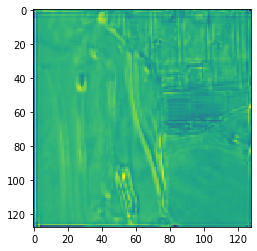

1


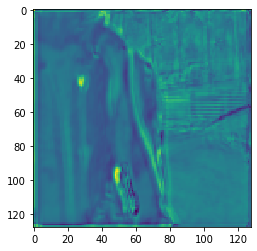

2


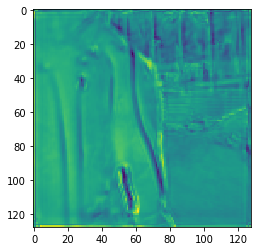

3


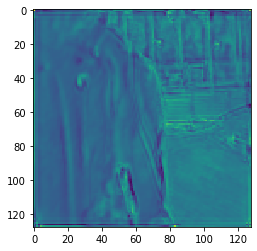

4


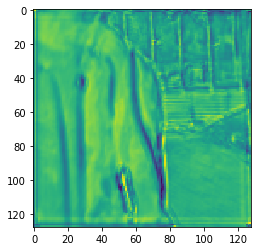

5


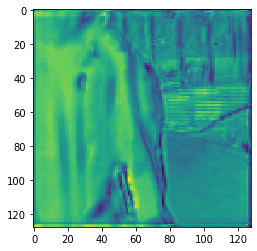

6


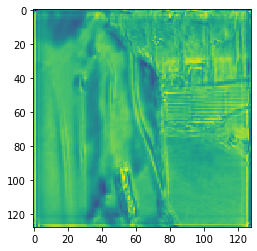

7


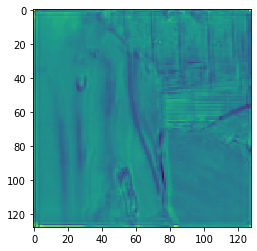

8


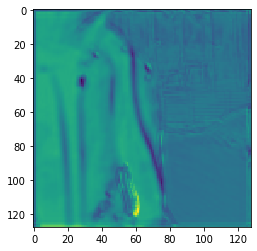

9


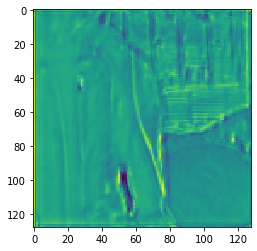

10


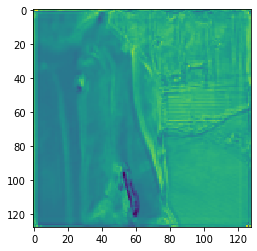

11


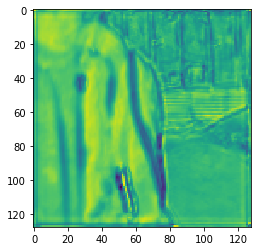

12


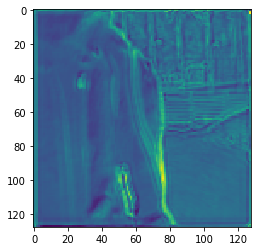

13


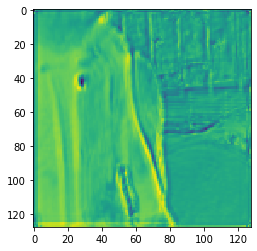

14


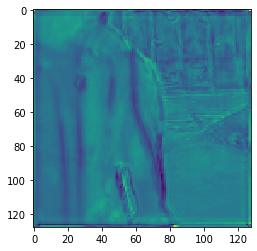

15


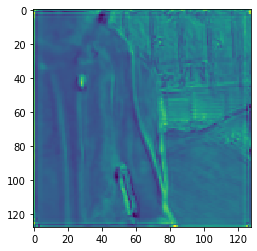

16


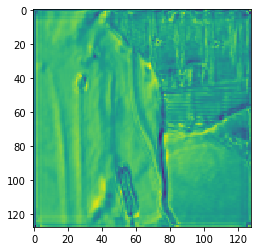

17


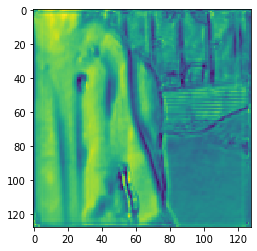

18


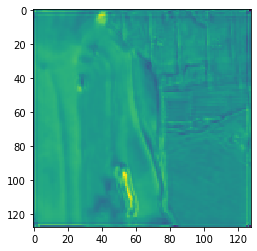

19


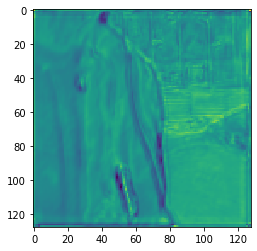

20


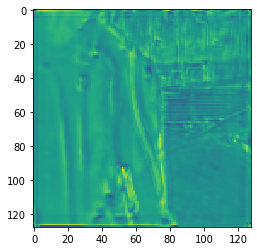

21


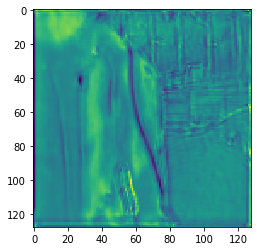

22


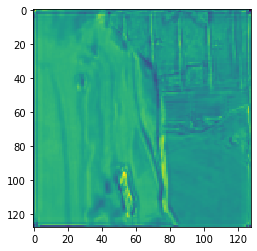

23


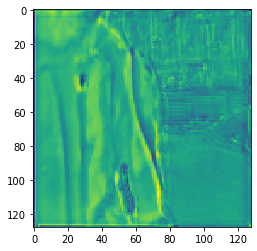

24


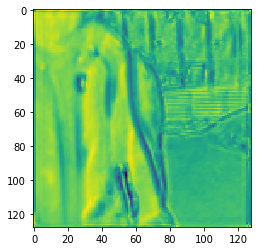

25


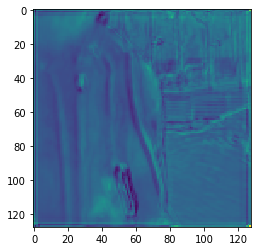

26


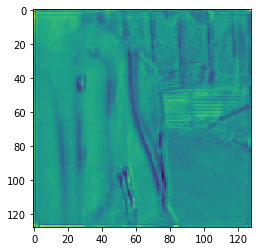

27


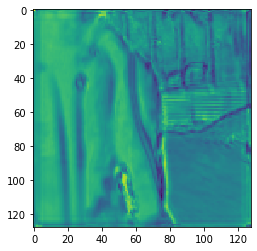

28


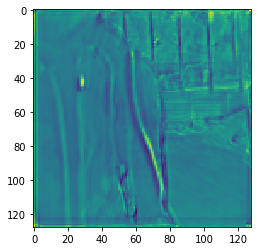

29


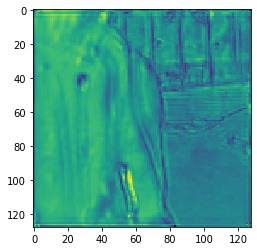

30


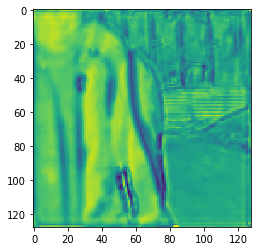

31


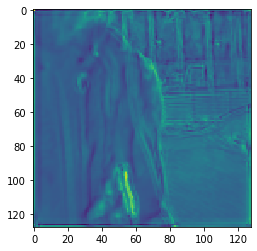

32


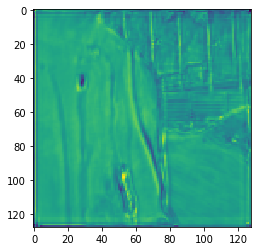

33


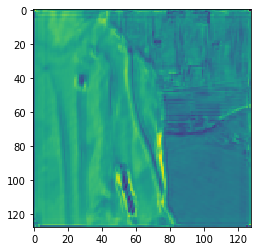

34


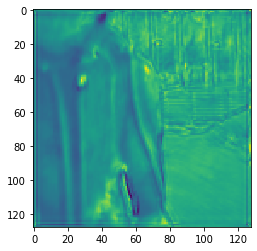

35


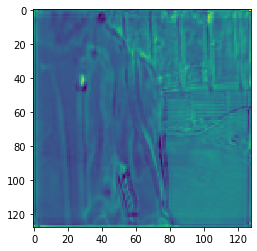

36


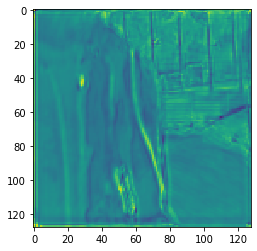

37


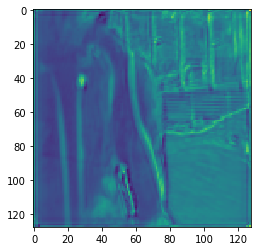

38


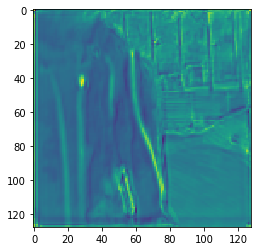

39


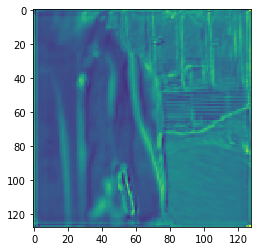

40


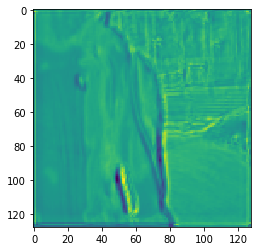

41


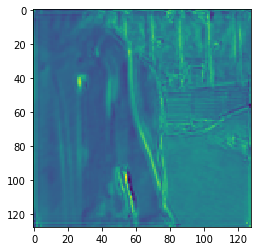

42


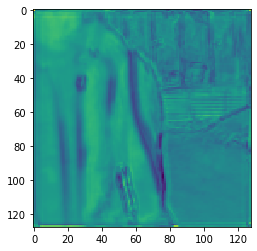

43


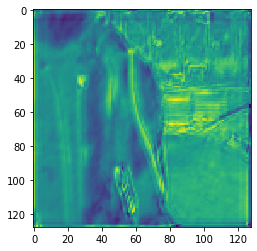

44


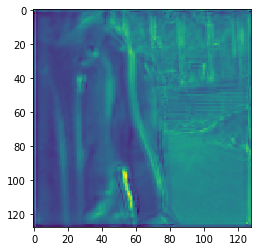

45


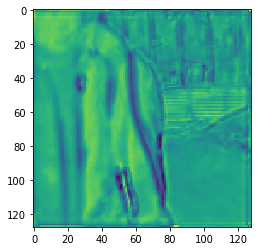

46


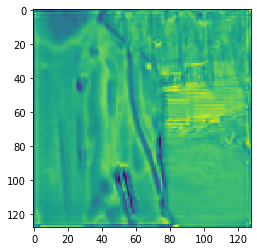

47


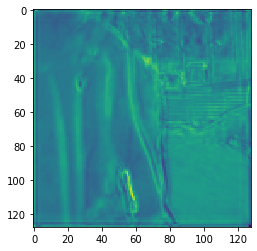

48


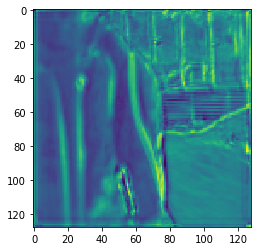

49


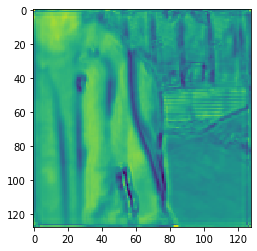

50


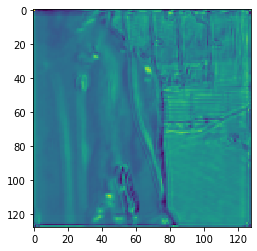

In [14]:
from matplotlib.pyplot import imshow
%matplotlib inline
for i in range(51):
    print(i)
    imshow(output[2][i].detach().cpu())
    plt.show()

In [23]:
x = torch.rand(8, 2)

In [24]:
x.shape

torch.Size([8, 2])

In [28]:
x.view(-1, 2, 2, 2).shape

torch.Size([2, 2, 2, 2])